In [120]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import geopandas as gpd
import matplotlib as mpl 
import matplotlib.colors as colors 
import matplotlib.cm as cm

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

### Problem 1

<font color=blue>Build a complete pipeline with a data set of your choice and a tree-based model of your choice in R (using tidymodels) or Python (using scikit-learn). For each step, include a paragraph explaining why you did that step the way you did (what components were included and, possibly, what you decided not to do).</font>
- <font color=blue>a brief description of where the data came from </font>


I chose data on the price of Airbnb listings in European cities, originally from [this publication](https://doi.org/10.1016/j.tourman.2021.104319), and accessed on [Kaggle](https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities). The data contains prices for various listings and descriptions of the listings (e.g. type of room, guest satisfaction rating, distance from city center). My goal is to predict the price of a listing.

- <font color=blue>some initial investigation of the data (which textual or graphical summaries did you investigate? Did you find anything unusual?)  </font>

In [2]:
## combine city and weekday/weekend data
berlin_wdays = pd.read_csv("airbnb/berlin_weekdays.csv", index_col=[0])
berlin_wdays['city'] = 'Berlin'
berlin_wdays['weekend'] = False
berlin_wends = pd.read_csv("airbnb/berlin_weekends.csv", index_col=[0])
berlin_wends['city'] = 'Berlin'
berlin_wends['weekend'] = True
budapest_wdays = pd.read_csv("airbnb/budapest_weekdays.csv", index_col=[0])
budapest_wdays['city'] = 'Budapest'
budapest_wdays['weekend'] = False
budapest_wends = pd.read_csv("airbnb/budapest_weekends.csv", index_col=[0])
budapest_wends['city'] = 'Budapest'
budapest_wends['weekend'] = True
lisbon_wdays = pd.read_csv("airbnb/lisbon_weekdays.csv", index_col=[0])
lisbon_wdays['city'] = 'Lisbon'
lisbon_wdays['weekend'] = False
lisbon_wends = pd.read_csv("airbnb/lisbon_weekends.csv", index_col=[0])
lisbon_wends['city'] = 'Lisbon'
lisbon_wends['weekend'] = True
london_wdays = pd.read_csv("airbnb/london_weekdays.csv", index_col=[0])
london_wdays['city'] = 'London'
london_wdays['weekend'] = False
london_wends = pd.read_csv("airbnb/london_weekends.csv", index_col=[0])
london_wends['city'] = 'London'
london_wends['weekend'] = True
paris_wdays = pd.read_csv("airbnb/paris_weekdays.csv", index_col=[0])
paris_wdays['city'] = 'Paris'
paris_wdays['weekend'] = False
paris_wends = pd.read_csv("airbnb/paris_weekends.csv", index_col=[0])
paris_wends['city'] = 'Paris'
paris_wends['weekend'] = True
rome_wdays = pd.read_csv("airbnb/rome_weekdays.csv", index_col=[0])
rome_wdays['city'] = 'Rome'
rome_wdays['weekend'] = False
rome_wends = pd.read_csv("airbnb/rome_weekends.csv", index_col=[0])
rome_wends['city'] = 'Rome'
rome_wends['weekend'] = True
vienna_wdays = pd.read_csv("airbnb/vienna_weekdays.csv", index_col=[0])
vienna_wdays['city'] = 'Vienna'
vienna_wdays['weekend'] = False
vienna_wends = pd.read_csv("airbnb/vienna_weekends.csv", index_col=[0])
vienna_wends['city'] = 'Vienna'
vienna_wends['weekend'] = True

master_df = pd.concat([berlin_wdays, berlin_wends, budapest_wdays, budapest_wends, 
                       lisbon_wdays, lisbon_wends, london_wdays, london_wends, 
                      paris_wdays, paris_wends, rome_wdays, rome_wends, vienna_wdays, vienna_wends], axis=0)
master_df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,weekend
0,185.799757,Private room,False,True,2.0,True,0,0,10.0,98.0,...,3.582211,0.174706,105.063708,16.019042,148.941114,30.710638,13.42344,52.49150,Berlin,False
1,194.914462,Private room,False,True,5.0,False,0,1,9.0,86.0,...,3.525410,0.511922,75.339529,11.487002,106.442356,21.947685,13.46800,52.51900,Berlin,False
2,176.217631,Private room,False,True,2.0,False,0,0,9.0,91.0,...,3.801713,0.281397,73.669176,11.232324,105.440205,21.741048,13.47096,52.51527,Berlin,False
3,207.768533,Private room,False,True,3.0,True,0,0,10.0,97.0,...,0.982408,0.705573,133.187409,20.307057,198.233362,40.874362,13.42281,52.53139,Berlin,False
4,150.743199,Private room,False,True,2.0,False,0,0,10.0,99.0,...,8.869697,2.187188,39.860151,6.077469,50.996308,10.515090,13.52440,52.47842,Berlin,False


In [49]:
for col in ["room_type", "city"]:
    master_df[col] = master_df[col].astype("category")
for col in ["multi", "biz"]:
    master_df[col] = master_df[col].astype(bool)
master_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41514 entries, 0 to 1798
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   realSum                     41514 non-null  float64 
 1   room_type                   41514 non-null  category
 2   room_shared                 41514 non-null  bool    
 3   room_private                41514 non-null  bool    
 4   person_capacity             41514 non-null  float64 
 5   host_is_superhost           41514 non-null  bool    
 6   multi                       41514 non-null  bool    
 7   biz                         41514 non-null  bool    
 8   cleanliness_rating          41514 non-null  float64 
 9   guest_satisfaction_overall  41514 non-null  float64 
 10  bedrooms                    41514 non-null  int64   
 11  dist                        41514 non-null  float64 
 12  metro_dist                  41514 non-null  float64 
 13  attr_index       

There appears to be no missing data. Now I want to check if the data are well balanced for features (e.g. city, room type). 

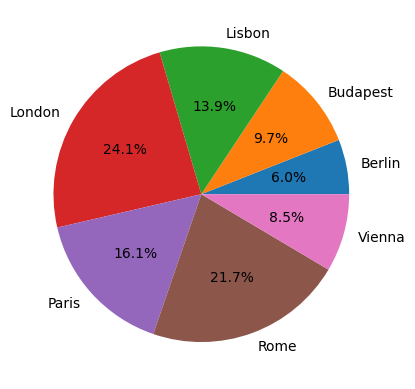

In [4]:
## cities are not equally represented in the data

cities, counts = np.unique(master_df["city"], return_counts=True)
plt.pie(counts, labels=cities, autopct='%1.1f%%')
plt.show()

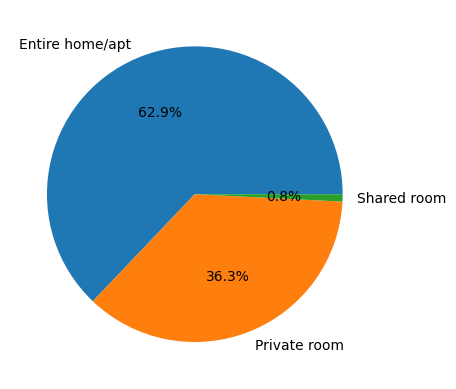

In [5]:
## room types are heavily skewed

rooms, r_counts = np.unique(master_df["room_type"], return_counts=True)
plt.pie(r_counts, labels=rooms, autopct='%1.1f%%')
plt.show()

It seems reasonable to think that prices might correlate with the distance to the city center ```dist``` and distance to the nearest subway station ```metro_dist```. I check this below for each of the cities:

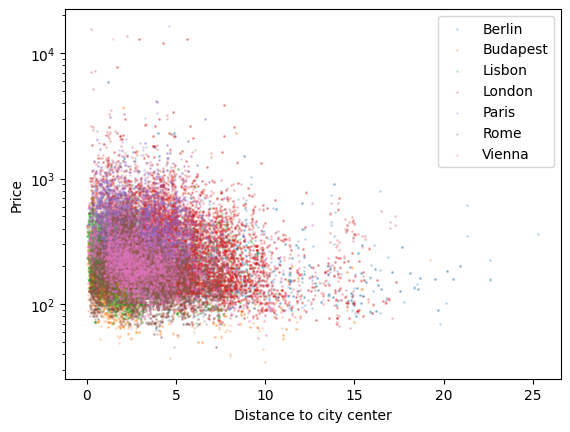

In [6]:
for c in cities:
    df = master_df[master_df["city"]==c]
    plt.scatter(df["dist"], df["realSum"], label=c, alpha=0.2, s=1)
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel("Distance to city center")
plt.ylabel("Price")
plt.show()

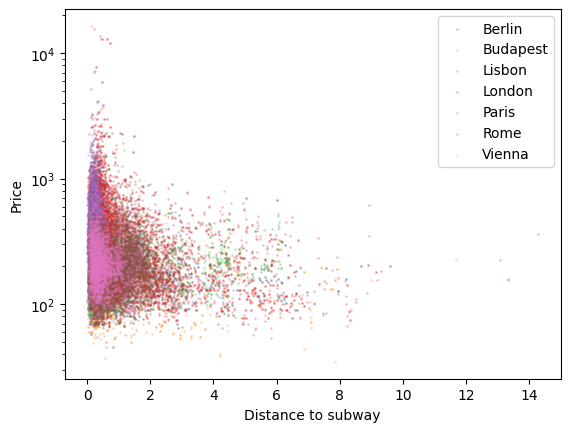

In [7]:
for c in cities:
    df = master_df[master_df["city"]==c]
    plt.scatter(df["metro_dist"], df["realSum"], label=c, alpha=0.2, s=1)
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel("Distance to subway")
plt.ylabel("Price")
plt.show()

I would have liked to convert latitude and longitude data into categorical neighbourhoods/zipcodes, but could not readily find the data to do so. I wanted to see if location played a role in pricing for the city with the largest number of data points: London, to see if these features were worth including in the model.

/var/folders/vh/dkh7yfgd01q_ngwks4pyljzc0000gn/T/ipykernel_3161/3641526311.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mapper)


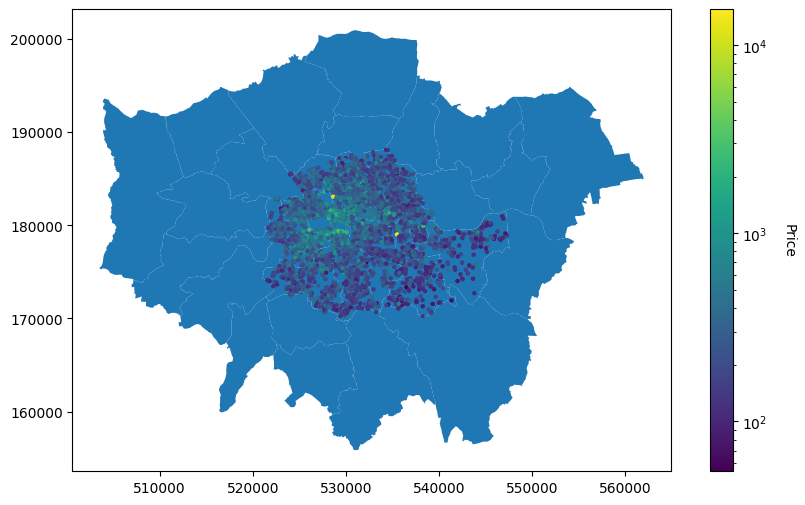

In [42]:
## projecting latitude and longitude data onto map of London

london_map = gpd.read_file("London_Boroughs.gpkg")
london_df = master_df[master_df["city"]=="London"]
gdf = gpd.GeoDataFrame(london_df, geometry=gpd.points_from_xy(london_df["lng"], london_df["lat"]))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:27700")

## assign listings colors according to price
norm = colors.LogNorm(vmin=min(gdf["realSum"]), vmax=max(gdf["realSum"]))
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
cs = mapper.to_rgba(gdf["realSum"])

gdf.plot(ax=london_map.plot(figsize=(10, 6)), color=cs, markersize=4)
cbar = plt.colorbar(mapper)
cbar.ax.set_ylabel("Price", rotation=270, labelpad=20)
plt.show()

It appears that latitude and longitude may convey a bit more information than the distance to the center of the city, since it appears the northern listings are priced more than the southern listings. I will keep these features in the following analysis. 

- <font color=blue>preprocessing step(s) (scaling, feature engineering/variable selection {based on predictors only}, lumping or dropping categories from predictors, one-hot encoding, etc.) </font> 


`room_shared` and `room_private` are redundant with the `room_type` column, and are removed. I also remove the unnormalized `attr_index` and `rest_index` and kept the normalized `attr_index_norm` and `rest_index_norm`. In the beginning, by combining all the cities and the weekend and weekday data into the `master_df` table, I introduced the additional features `city` (categorical) and `weekend` (boolean).

In [ ]:
## statistical tests for whether multi and biz columns have any impact on price

Additionally, I need to convert the categorical features `room_type` and `city` into an encoding that can be fed into my model. As I am interested in applying an ensemble method (random forest or gradient-boosted trees), I want to avoid one-hot-encoding as it would greatly increase the number of features in my data, which might affect performance if I am growing very shallow trees.  

Instead, I will use target encoding, because my categorical features are unbalanced (see pie charts above), the ideal is leave-one-out target encoding with regularization described [here](https://stats.stackexchange.com/a/567125) to minimize data leakage. This introduces an additional hyperparemters per categorical feature, $N_{\text{pseudo}}$, which controls the regularization such that the target encoding is given by 

$$\frac{N_{\text{pseudo}}}{N_{\text{category}}+N_{\text{pseudo}}} \times \text{overall average} + \frac{N_{\text{category}}}{N_{\text{category}}+N_{\text{pseudo}}} \times \text{average for category}$$

Leave-one-out target encoding prevents direct data leakage from the target to the feature for each observation, and the regularization (which is stronger for categories for which there are less data) helps to reduce indirect data leakage where the target value may be back-computed from the encodings of the other training data (which may occur in the case where only the average for each category is used). 

First, I need to do the test-train split before target encoding to prevent data leakage. 

In [52]:
X = master_df[["room_type", "person_capacity", "host_is_superhost", \
                "multi", "biz", "cleanliness_rating", "guest_satisfaction_overall",\
                "bedrooms", "dist", "metro_dist", "attr_index_norm", "rest_index_norm",\
                "lng", "lat", "city", "weekend"]]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41514 entries, 0 to 1798
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   room_type                   41514 non-null  category
 1   person_capacity             41514 non-null  float64 
 2   host_is_superhost           41514 non-null  bool    
 3   multi                       41514 non-null  bool    
 4   biz                         41514 non-null  bool    
 5   cleanliness_rating          41514 non-null  float64 
 6   guest_satisfaction_overall  41514 non-null  float64 
 7   bedrooms                    41514 non-null  int64   
 8   dist                        41514 non-null  float64 
 9   metro_dist                  41514 non-null  float64 
 10  attr_index_norm             41514 non-null  float64 
 11  rest_index_norm             41514 non-null  float64 
 12  lng                         41514 non-null  float64 
 13  lat              

In [104]:
y = master_df["realSum"]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

I ran out of time for implementing my own target encoder described above

I ended up using an out of the box target encoder which did not implmenent leave-one-out, but added gaussian noise. 

In [ ]:
from category_encoders import MEstimateEncoder

- <font color=blue>model choice (What model classes did you pick? Why?) </font>  

I chose a random forest because few of the features are expected to be irrelevant to the price, and a random forest is expected to give fairly accurate predictions in this case. It also allows me to analyse the variable importance, which I want in order to gain some intuition about the strongest determinants of price. 

In [121]:
pipeline = Pipeline([
    ("room_encoder", MEstimateEncoder(cols=["room_type"], m=5.0)), 
    ("city_encoder", MEstimateEncoder(cols=["city"], m=5.0)),
    ('regressor', RandomForestRegressor(n_estimators=100))
])


## R^2 value with default parameters:
pipeline.fit(X_train, y_train)
r2 = pipeline.score(X_test, y_test)
print(r2)

0.391147915056


- <font color=blue>model tuning (What hyperparameters did you tune? How? What loss function did you use and why? What was the range of achieved/minimized loss functions?)  </font> 

I tuned the smoothing parameter for the target encodings, the maximum depth of the tree, the minimum number of samples required to split an internal node, the minimum number of samples required to be at a leaf node, the number of features to consider when looking for the best split, the maximum number of leaf nodes, and the number of trees. 

I used the squared error as this was a regression problem, and alternatives like the absolute error turned out to be computationally too expensive. 

In [153]:
pipeline = Pipeline([
    ("room_encoder", MEstimateEncoder(cols=["room_type"])), 
    ("city_encoder", MEstimateEncoder(cols=["city"])),
    ('regressor', RandomForestRegressor(n_estimators=100))
])

params = {
    "room_encoder__m":[1.0, 5.0], # smoothing factor for target encoding
    "city_encoder__m":[1.0, 5.0],
    "regressor__max_depth": [2, 3, None], # default None
    "regressor__max_leaf_nodes": [10, 20, None], # default None
    "regressor__min_samples_split": [2, 10], # default 2
    "regressor__max_features": ["sqrt", None], # default None=n_features
    "regressor__min_samples_leaf":[1, 2, 5], # default is 1
    "regressor__n_estimators": [100, 200], # default 100
}

In [152]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'room_encoder', 'city_encoder', 'regressor', 'room_encoder__cols', 'room_encoder__drop_invariant', 'room_encoder__handle_missing', 'room_encoder__handle_unknown', 'room_encoder__m', 'room_encoder__random_state', 'room_encoder__randomized', 'room_encoder__return_df', 'room_encoder__sigma', 'room_encoder__verbose', 'city_encoder__cols', 'city_encoder__drop_invariant', 'city_encoder__handle_missing', 'city_encoder__handle_unknown', 'city_encoder__m', 'city_encoder__random_state', 'city_encoder__randomized', 'city_encoder__return_df', 'city_encoder__sigma', 'city_encoder__verbose', 'regressor__bootstrap', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__max_samples', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_jobs', 'regressor

- <font color=blue>determining and fitting the best model</font> 

I used a randomized hyperparameters search using cross validation, which randomly selected parameters from the list above and executed 20 times to find a good set of parameters. 

In [154]:
clf = RandomizedSearchCV(pipeline, params, n_iter=20)
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('room_encoder',
                                              MEstimateEncoder(cols=['room_type'])),
                                             ('city_encoder',
                                              MEstimateEncoder(cols=['city'])),
                                             ('regressor',
                                              RandomForestRegressor())]),
                   n_iter=20,
                   param_distributions={'city_encoder__m': [1.0, 5.0],
                                        'regressor__max_depth': [2, 3, None],
                                        'regressor__max_features': ['sqrt',
                                                                    None],
                                        'regressor__max_leaf_nodes': [10, 20,
                                                                      None],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        5],
                                        'regressor__min_samples_split': [2, 10],
                                        'regressor__n_estimators': [100, 200],
                                        'room_encoder__m': [1.0, 5.0]})

In [164]:
results = pd.DataFrame(clf.cv_results_)
results = results.sort_values("rank_test_score")
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_room_encoder__m,param_regressor__n_estimators,param_regressor__min_samples_split,param_regressor__min_samples_leaf,param_regressor__max_leaf_nodes,param_regressor__max_features,...,param_city_encoder__m,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,3.314962,0.015983,0.121402,0.001881,1.0,100,2,1,None,sqrt,...,1.0,"{'room_encoder__m': 1.0, 'regressor__n_estimat...",0.292240,0.228146,0.672245,0.434820,0.576225,0.440735,0.166874,1
18,20.988758,0.131085,0.173398,0.002384,5.0,200,10,1,None,None,...,1.0,"{'room_encoder__m': 5.0, 'regressor__n_estimat...",0.260197,0.090110,0.438830,0.353689,0.519208,0.332407,0.148725,2
19,2.071283,0.028087,0.036335,0.000682,5.0,200,10,2,20,sqrt,...,1.0,"{'room_encoder__m': 5.0, 'regressor__n_estimat...",0.203669,0.318979,0.435608,0.256293,0.359213,0.314753,0.080446,3
4,7.407877,0.106901,0.034256,0.000660,5.0,200,2,5,20,None,...,1.0,"{'room_encoder__m': 5.0, 'regressor__n_estimat...",0.201950,0.259239,0.379877,0.253363,0.360075,0.290901,0.067861,4
12,6.251591,0.076048,0.027774,0.000379,5.0,200,10,5,10,None,...,1.0,"{'room_encoder__m': 5.0, 'regressor__n_estimat...",0.174619,0.228518,0.337102,0.212190,0.283723,0.247230,0.057025,5


In [156]:
results["params"][10]

{'room_encoder__m': 1.0,
 'regressor__n_estimators': 100,
 'regressor__min_samples_split': 2,
 'regressor__min_samples_leaf': 1,
 'regressor__max_leaf_nodes': None,
 'regressor__max_features': 'sqrt',
 'regressor__max_depth': None,
 'city_encoder__m': 1.0}

The best model out of the 20 randomly tried was applied to the test set

In [157]:
pipeline = Pipeline([
    ("room_encoder", MEstimateEncoder(cols=["room_type"], m=1.0)), 
    ("city_encoder", MEstimateEncoder(cols=["city"], m=1.0)),
    ('regressor', RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None, max_features='sqrt', max_depth=None))
])


## R^2 value with optimized model:
pipeline.fit(X_train, y_train)
r2 = pipeline.score(X_test, y_test)
print(r2)

0.4912129239028461


- <font color=blue>evaluate and explain the results of the model (partial dependence plots, variable importance, etc.)</font> 

In [158]:
rf_regressor = pipeline['regressor']
feature_importances = rf_regressor.feature_importances_

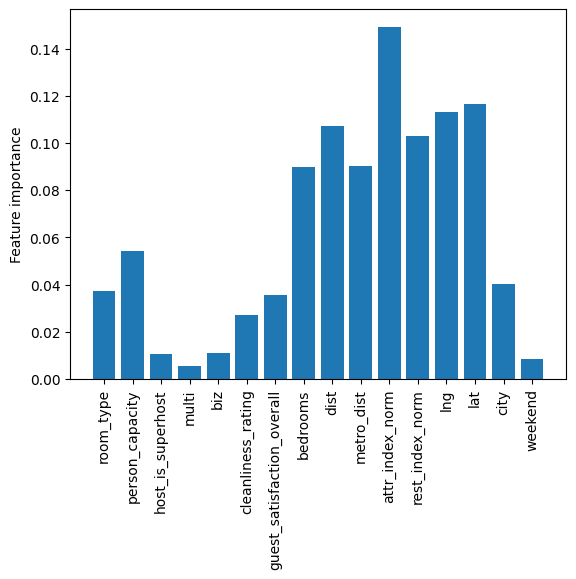

In [160]:
plt.bar(X_train.columns.values, feature_importances)
plt.xticks(rotation='vertical')
plt.ylabel("Feature importance")
plt.show()

The $R^2$ value of 0.49 of even the best model is quite low, and there are some aspects of the feature importance plot which are surprising. I would have thought the type of room (e.g. entire apartment vs shared room), and the city would have been more important features. 